<a href="https://colab.research.google.com/github/KeremAydin98/skimlit/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the data

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.


In [2]:
path_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"
train_dir = path_dir + "/train.txt"
val_dir = path_dir + "/dev.txt"
test_dir = path_dir + "/test.txt"

In [3]:
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [4]:
sentences = get_lines(train_dir)
sentences[:14]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

# Preprocess data

In [5]:
def preprocess_data(filename):

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []


  for line in input_lines:

    if line.startswith("###"):

      abstract_id = line
      abstract_lines = "" # reset the abstract line

    elif line.isspace():

      abstract_line_split = abstract_lines.splitlines() # splitlines(): Split a string into a list where each line is a list item:
    
      # Iterate through each line
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):

        line_data = {}

        target_text_split = abstract_line.split("\t") #Split target label from text

        line_data["target"] = target_text_split[0] # get the target label
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else:

      abstract_lines += line

  
  return abstract_samples  

In [6]:
train_samples = preprocess_data(train_dir)
val_samples = preprocess_data(val_dir)
test_samples = preprocess_data(test_dir)

In [7]:
train_samples[0]

{'line_number': 0,
 'target': 'OBJECTIVE',
 'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'total_lines': 11}

In [8]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [9]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [10]:
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()

In [11]:
train_labels = train_df["target"].to_list()
val_labels = val_df["target"].to_list()
test_labels = test_df["target"].to_list()

In [12]:
train_line_number = train_df["line_number"].to_list()
val_line_number = val_df["line_number"].to_list()
test_line_number = test_df["line_number"].to_list()

In [13]:
train_total_lines = train_df["total_lines"].to_list()
val_total_lines = val_df["total_lines"].to_list()
test_total_lines = test_df["total_lines"].to_list()

In [14]:
train_df["target"].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

# Encode and One hot encode the dataset

In [15]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [16]:
def encode_labels(train_labels, val_labels):

  le = LabelEncoder()

  train_labels_encoded = le.fit_transform(train_labels)
  val_labels_encoded = le.transform(val_labels)

  return train_labels_encoded, val_labels_encoded

In [17]:
train_labels_encoded, val_labels_encoded = encode_labels(train_labels, val_labels)

In [18]:
def one_hot_labels(train_df, val_df):

  one_hot = OneHotEncoder(sparse=False)

  train_labels_one_hot = one_hot.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
  val_labels_one_hot = one_hot.transform(val_df["target"].to_numpy().reshape(-1,1))

  return train_labels_one_hot, val_labels_one_hot

In [19]:
train_labels_one_hot, val_labels_one_hot =  one_hot_labels(train_df, val_df)

In [51]:
import numpy as np
percentage = int(np.percentile(train_line_number, 98))
percentage

15

In [23]:
import tensorflow as tf

In [52]:
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),depth=percentage)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),depth=percentage)

In [53]:
train_line_number_one_hot.shape,train_line_number_one_hot.dtype

(TensorShape([180040, 15]), tf.float32)

In [54]:
percentage = int(np.percentile(train_total_lines, 98))
percentage

20

In [55]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(),depth=percentage)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(),depth=percentage)

In [56]:
train_total_lines_one_hot.shape,train_total_lines_one_hot.dtype

(TensorShape([180040, 20]), tf.float32)

# Char Vectorization, Pretrained Embedding 

In [31]:
def split_chars(sentence):

  delimiter = " "

  return delimiter.join(list(sentence))

In [32]:
import string 

alphabet = string.ascii_lowercase + string.digits + string.punctuation
num_chars = len(alphabet) + 2

In [33]:
len(alphabet), alphabet

(68, 'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

In [34]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [35]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [36]:
all_chars = [len(sentence) for sentence in train_sentences]
np.mean(all_chars)

149.3662574983337

In [37]:
percentage = int(np.percentile(all_chars, 95))
percentage

290

In [38]:
import tensorflow as tf

char_vectorization = tf.keras.layers.TextVectorization(max_tokens=num_chars,
                                                       output_sequence_length=percentage)

In [39]:
char_vectorization.adapt(train_chars)

In [40]:
char_embedding = tf.keras.layers.Embedding(input_dim=num_chars,
                                           output_dim=25) # from paper

In [41]:
# The paper has used Glove but since it is not in tensorfow hub, I used universal sentence encoder
import tensorflow_hub as hub
token_embeddings_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable=False)

# Create the model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the line number feature
4. Create a model for the total lines feature
5. Combine the outputs of 1 and 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3,4 and 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities 
8. Combine the inputs of 1,2,3,4 and outputs of into a tf.keras.Model 

In [58]:
# 1. Token embeddings
token_inputs = tf.keras.layers.Input(shape=(),dtype=tf.string,name="token_input")
x = token_embeddings_layer(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation="relu")(x)

token_model = tf.keras.models.Model(token_inputs, token_outputs)

# 2. Char vectorization
char_inputs = tf.keras.layers.Input(shape=(1,),dtype=tf.string,name="char_input")
x = char_vectorization(char_inputs)
x = char_embedding(x)
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(x)

char_model = tf.keras.models.Model(char_inputs, char_outputs)

# 3. Line number feature
line_number_input = tf.keras.layers.Input(shape=(15,),dtype=tf.float64,name="line_number_input")
line_number_output = tf.keras.layers.Dense(128, activation="relu")(line_number_input)

line_number_model = tf.keras.models.Model(line_number_input, line_number_output)

# 4. Total lines feature
total_lines_input = tf.keras.layers.Input(shape=(20,),dtype=tf.float64,name="total_lines_input")
total_lines_output = tf.keras.layers.Dense(128, activation="relu")(total_lines_input)

total_lines_model = tf.keras.models.Model(total_lines_input, total_lines_output)

# 5. Concatenate token and char models
concat_embeddings = tf.keras.layers.Concatenate()([token_model.output,
                                           char_model.output])

z = tf.keras.layers.Dense(256,activation="relu")(concat_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)


# 6. Tribrid model
tribrid_output = tf.keras.layers.Concatenate()([line_number_model.output,
                                            total_lines_model.output,
                                            z])

# 7. Output layer
z = tf.keras.layers.Dropout(0.5)(tribrid_output)
outputs = tf.keras.layers.Dense(5,activation="softmax")(z)

# 8. Combine all the models
model = tf.keras.models.Model(inputs=[token_model.input,
                                     char_model.input,
                                     line_number_model.input,
                                     total_lines_model.input],
                              outputs=[outputs])

# Compile the model
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])


In [43]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 290)         0           ['char_input[0][0]']             
 ization)                                                                                         
                                                                                                  
 keras_layer (KerasLayer)       (None, 512)          256797824   ['token_input[0][0]']      

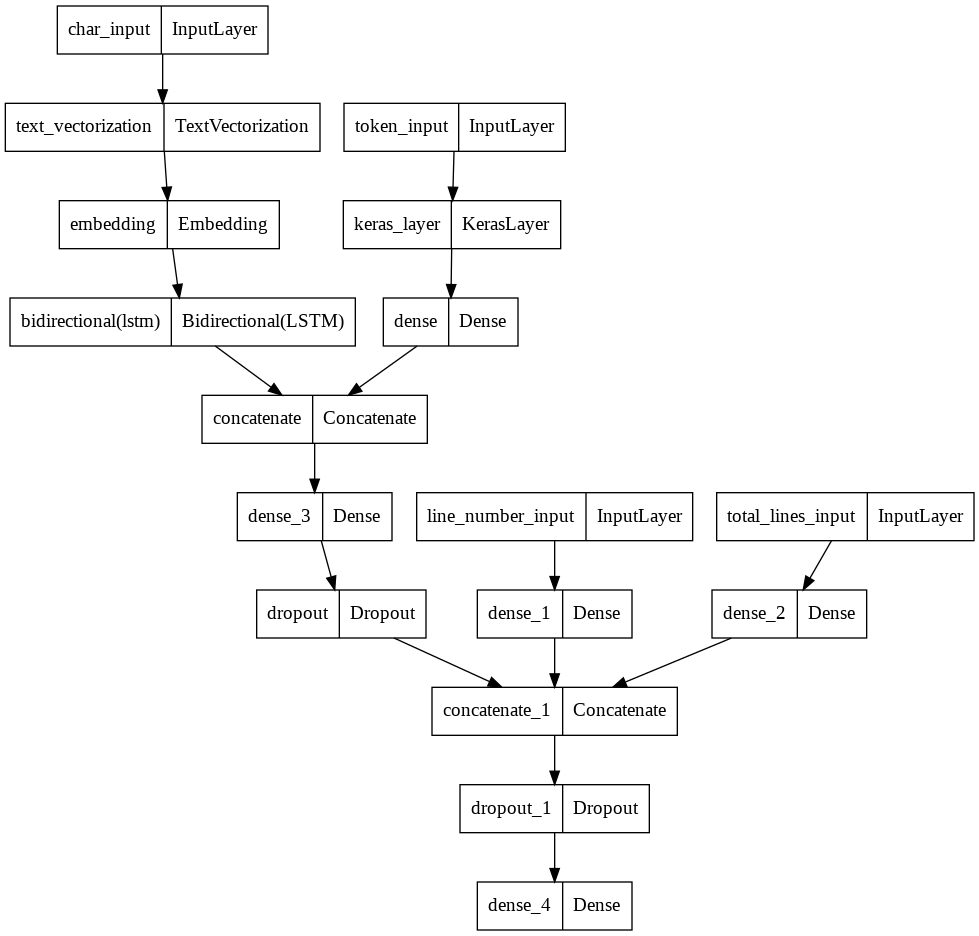

In [44]:
from tensorflow.keras.utils import plot_model
plot_model(model)

# Create the datasets using tf.data.Dataset

In [59]:
train_features = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars, 
                                                    train_line_number_one_hot, train_total_lines_one_hot))

train_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_dataset = tf.data.Dataset.zip((train_features, train_labels))

val_features = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars, val_line_number_one_hot, val_total_lines_one_hot))
val_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset = tf.data.Dataset.zip((val_features, val_labels))

train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Fit the model

In [60]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Epoch 1/5
5627/5627 [==============================] - 649s 113ms/step - loss: 1.0089 - accuracy: 0.6003 - val_loss: 0.6437 - val_accuracy: 0.7468
Epoch 2/5
5627/5627 [==============================] - 641s 114ms/step - loss: 0.6376 - accuracy: 0.7480 - val_loss: 0.5500 - val_accuracy: 0.7804
Epoch 3/5
5627/5627 [==============================] - 638s 113ms/step - loss: 0.5778 - accuracy: 0.7741 - val_loss: 0.5114 - val_accuracy: 0.8001
Epoch 4/5
5627/5627 [==============================] - 642s 114ms/step - loss: 0.5448 - accuracy: 0.7890 - val_loss: 0.4877 - val_accuracy: 0.8117
Epoch 5/5
5627/5627 [==============================] - 641s 114ms/step - loss: 0.5256 - accuracy: 0.7978 - val_loss: 0.4733 - val_accuracy: 0.8165


# Evaluate the model

In [61]:
model.evaluate(val_dataset)

945/945 [==============================] - 52s 55ms/step - loss: 0.4733 - accuracy: 0.8165


[0.4732833802700043, 0.8165298700332642]

In [65]:
model_preds_probs = model.predict(val_dataset)
model_preds_probs

array([[6.1665958e-01, 9.6600289e-03, 1.2726343e-04, 3.7314638e-01,
        4.0681835e-04],
       [7.4208909e-01, 8.2855364e-03, 4.9852543e-03, 2.4427193e-01,
        3.6814439e-04],
       [3.6706987e-01, 4.8672389e-02, 4.9964666e-02, 4.9478847e-01,
        3.9504673e-02],
       ...,
       [1.8341468e-04, 1.1473649e-02, 8.2676010e-03, 3.5402027e-05,
        9.8003995e-01],
       [9.5214252e-04, 6.2820077e-02, 1.5552449e-02, 1.4066494e-04,
        9.2053467e-01],
       [4.8097616e-01, 2.1756546e-01, 2.2268201e-01, 3.6447784e-03,
        7.5131543e-02]], dtype=float32)

In [66]:
model_preds = tf.argmax(model_preds_probs, axis=1)
model_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 0])>

In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

In [95]:
def calculate_results(y_true, y_pred):

  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred,average='weighted')
  recall = recall_score(y_true, y_pred,average='weighted')
  f1 = f1_score(y_true, y_pred,average='weighted')

  results = {"accuracy":accuracy,
             "precision":precision,
             "recall":recall,
             "f1_score":f1}

  final_results = pd.DataFrame(results,index=["Model"])

  return final_results

In [96]:
model_results = calculate_results(val_labels_encoded, model_preds)
model_results = model_results.transpose()
model_results

,Model
accuracy,0.816530
precision,0.816183
recall,0.816530
f1_score,0.814067


In [97]:
import matplotlib.pyplot as plt

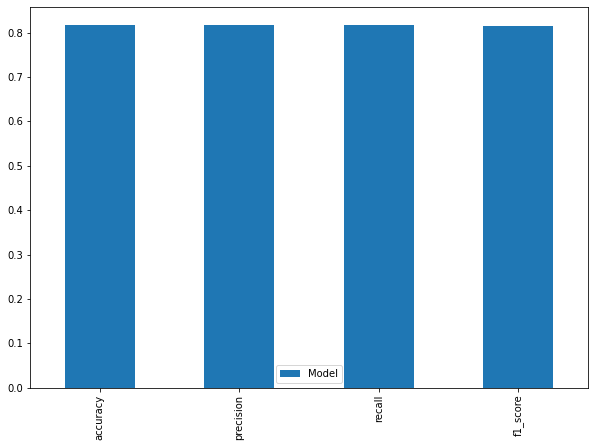

In [99]:
model_results.plot(kind="bar",figsize=(10,7))